In [627]:
import pandas as pd 
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.api as sm
from matplotlib.ticker import FuncFormatter
from datetime import datetime
import yfinance as yf
import random
from sklearn.linear_model import LinearRegression

In [628]:
with open('hash-rate.json') as f:
    data = pd.read_json(f)

#https://www.blockchain.com/explorer/charts/hash-rate

In [629]:
with open('miners-revenue.json') as g:
    data2 = pd.read_json('miners-revenue.json', lines=True) 
    
# https://www.blockchain.com/explorer/charts/miners-revenue

## Bitcoin Historical Volatility

In [630]:
btc = yf.Ticker("BTC-USD")
btc_history = btc.history(period="10y", interval="1d")
btc_prices = pd.DataFrame(btc_history).reset_index()

btc_prices["Date"] = pd.to_datetime(btc_prices["Date"]).dt.date

start_date = pd.to_datetime('11-01-2020').date()
end_date = pd.to_datetime('01-01-2022').date()
yearly = pd.to_datetime('11-01-2023').date()

# Now perform the filtering
btc_prices_bull = btc_prices[(btc_prices["Date"] >= start_date) & (btc_prices["Date"] <= end_date)]
btc_prices = btc_prices[(btc_prices["Date"] >= start_date)]
btc_prices_bear = btc_prices[(btc_prices["Date"] >= yearly)]

def calculate_historical_volatility(prices, trading_days=252):
    # Step 1: Calculate daily returns
    returns = prices.pct_change().dropna()
    
    # Step 2: Calculate the standard deviation of daily returns
    daily_volatility = np.std(returns)
    
    # Step 3: Annualize the volatility
    annualized_volatility = daily_volatility #* np.sqrt(trading_days)
    
    return annualized_volatility


calculate_historical_volatility(btc_prices["Close"])

0.03269242955172506

In [631]:
def generate_array_prev(N, start, top, end):
    half = N // 2  # Determine the halfway point
    if N % 2 == 0:
        # If N is even, split the increase and decrease evenly
        increasing = np.linspace(start, top, half, endpoint=False)
        decreasing = np.linspace(top, end, half)
    else:
        # If N is odd, make the peak value stay in the middle
        increasing = np.linspace(start, top, half + 1, endpoint=True)
        decreasing = np.linspace(top, end, half + 1)[1:]

    return np.concatenate([increasing, decreasing])


def generate_array(N, start, top, end, volatility = calculate_historical_volatility(btc_prices["Close"]), mean_reversion=.45):
    # Normalize values for better fluctuation visibility
    start_norm = start / start 
    top_norm = top / start 
    end_norm = end / start 
    
    half = N // 2
    mp = ((N  - half) // 2) + half
    q3 = ((N  -  mp) // 2) + mp
    q1 = ((mp  -  half) // 2) + half

    bridge = np.zeros(N)
    bridge[0] = start_norm
    bridge[half] = top_norm
    bridge[-1] = end_norm
    
    for i in range(1, half):
        drift = mean_reversion * (top_norm - bridge[i - 1]) / (half - i)
        shock = np.random.normal(0, volatility)
        bridge[i] = bridge[i - 1] + drift + shock
    
    for i in range(half + 1, N):
        f = 0
        if N <= q1:
            f = N + mp 
        elif (N > q1) and (N <= q3):
            f = N - q1
        else:
            f = N

        drift = mean_reversion * (end_norm - bridge[i - 1]) / (f - i)
        shock = np.random.normal(0, volatility)
        bridge[i] = bridge[i - 1] + drift + shock
    
    # Scale back to original values
    return bridge * start  # Scale back to the original range


### Miner Historical Efficiency Analysis

C:\Users\bfass\AppData\Local\Temp\ipykernel_17156\3105362265.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pulled_miners["Release_Year"] = pulled_miners["Date of release"].dt.year
C:\Users\bfass\AppData\Local\Temp\ipykernel_17156\3105362265.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pulled_miners['Date_numeric'] = (pulled_miners['Date of release'] - min_date2).dt.days
c:\Users\bfass\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with 

                            OLS Regression Results                            
Dep. Variable:      Efficiency (J/Th)   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     157.7
Date:                Sat, 02 Nov 2024   Prob (F-statistic):           5.68e-05
Time:                        18:53:54   Log-Likelihood:                 7.9356
No. Observations:                   7   AIC:                            -11.87
Df Residuals:                       5   BIC:                            -11.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          445.2185     35.194     12.650   

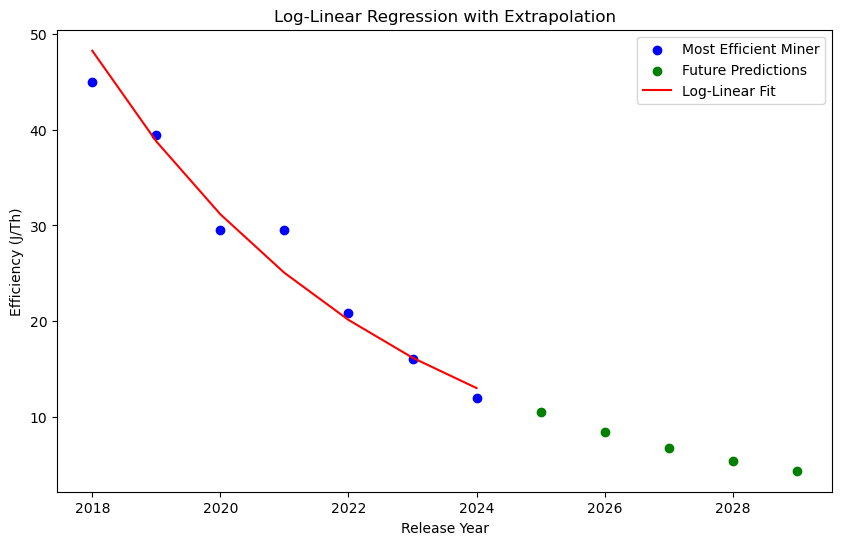

   Release_Year  Predicted_Efficiency
0          2025                 10.44
1          2026                  8.39
2          2027                  6.74
3          2028                  5.42
4          2029                  4.35


In [632]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load and filter the data
pulled_miners_pre = pd.read_excel("History_of_Miners.xlsx")
pulled_miners = pulled_miners_pre[pulled_miners_pre["Date of release"] >= "2018-01-01"]

# Extract release year and create numeric date column
pulled_miners["Release_Year"] = pulled_miners["Date of release"].dt.year
min_date2 = pulled_miners["Date of release"].min()
pulled_miners['Date_numeric'] = (pulled_miners['Date of release'] - min_date2).dt.days

# Aggregate data to get minimum efficiency per year
pm_adj = pulled_miners.groupby("Release_Year")["Efficiency (J/Th)"].min().reset_index()

# Define independent (X) and dependent (y) variables
X = pm_adj["Release_Year"]
y = pm_adj["Efficiency (J/Th)"]

# Apply log transformation to the dependent variable
log_y = np.log(y)

# Add a constant to the independent variable for the intercept
X_with_const = sm.add_constant(X)

# Fit the OLS model on the log-transformed dependent variable
model = sm.OLS(log_y, X_with_const).fit()

# Print the summary of the model
print(model.summary())

# Predict for the original data and back-transform
pm_adj["Log_Predicted_Efficiency"] = np.exp(model.predict(X_with_const))

# Create new years for extrapolation (next 5 years)
last_year = pm_adj["Release_Year"].max()
future_years = np.arange(last_year + 1, last_year + 6)

# Prepare the new data with a constant
future_X_with_const = sm.add_constant(future_years)

# Predict for the next 5 years and back-transform
future_predictions = np.exp(model.predict(future_X_with_const))

# Combine future predictions with original data for plotting
future_data = pd.DataFrame({
    "Release_Year": future_years,
    "Predicted_Efficiency": future_predictions
})

# Plot original data and future predictions
plt.figure(figsize=(10, 6))
plt.scatter(pm_adj["Release_Year"], y, label='Most Efficient Miner', color='blue')
plt.scatter(future_data["Release_Year"], future_data["Predicted_Efficiency"], color='green', label='Future Predictions')
plt.plot(pm_adj["Release_Year"], pm_adj["Log_Predicted_Efficiency"], color='red', label='Log-Linear Fit')


plt.xlabel('Release Year')
plt.ylabel('Efficiency (J/Th)')
plt.title('Log-Linear Regression with Extrapolation')
plt.legend()
plt.show()

# Display future predictions
print(future_data)


In [633]:
efficiency_frontier = pd.concat([pm_adj[["Release_Year", "Efficiency (J/Th)"]], future_data.rename(columns={"Predicted_Efficiency": "Efficiency (J/Th)"})])

## BTC Projections

In [696]:
def model(power_c):
    data[['Time', 'Global-Hashrate']] = data['hash-rate'].apply(pd.Series)
    data[['Time', 'BTC']] = data['market-price'].apply(pd.Series)
    data['date'] = pd.to_datetime(data['Time'], unit='ms')



    new_df = data[['Time', 'BTC', 'Global-Hashrate', 'date']]

    miner_rev = pd.DataFrame(data2["miners-revenue"][0])
    miner_rev.columns = ['Time', 'Avg_Miner_Reward']

    miner_rev['date_pre'] = pd.to_datetime(miner_rev['Time'], unit='ms')
    miner_rev['date']  = miner_rev['date_pre'] + (new_df["date"].max() - miner_rev['date_pre'].max())




    final_df = new_df.merge(miner_rev[["date", "Avg_Miner_Reward"]], on='date', how='left')
    final_df = final_df[final_df["date"] >= '2020-01-01']

    min_date = final_df['date'].min()
    final_df['days_from_min'] = (final_df['date'] - min_date).dt.days
    final_df["Hash_Price"] = (final_df["Avg_Miner_Reward"] * 1000)/final_df["Global-Hashrate"]


    final_df2 = final_df.copy()
    final_df2["Global-Hashrate"] = final_df2["Global-Hashrate"] / 1000
    final_df2["Hash_Price"] = final_df2["Avg_Miner_Reward"] / final_df2["Global-Hashrate"]
    final_df2["Block_Rewards"] = (final_df2["Avg_Miner_Reward"] / final_df2["BTC"]) / 144
    final_df2["Year"] = final_df2["date"].dt.year
    final_df2 = final_df2.merge(efficiency_frontier, how = 'left', left_on="Year", right_on = "Release_Year")
    final_df2.drop(columns = "Release_Year", inplace = True)










    proj = final_df2[["date","days_from_min", "BTC", "Avg_Miner_Reward"]]
    proj["Block_Rewards"] = (final_df2["Avg_Miner_Reward"] / 144) / final_df2["BTC"]
    proj

    dates_array = pd.date_range(start='2024-10-10', end='2028-05-01', freq='4D')
    reference_date = final_df['date'].min()
    days_from_reference = (dates_array - reference_date).days
    BTC = np.array(generate_array(len(dates_array), 70000,150000, random.uniform(75000, 125000)))


    guess = pd.DataFrame({
        "date": dates_array,
        "days_from_min":days_from_reference,
        "BTC_Base": BTC,
        "Avg_Miner_Reward": BTC * 144 * 3.4,
        "Block_Rewards": 3.4
    })

    proj = pd.concat([proj, guess], axis=0)

    #efficiency_frontier = pd.concat([pm_adj[["Release_Year", "Efficiency (J/Th)"]], future_data.rename(columns={"Predicted_Efficiency": "Efficiency (J/Th)"})])

    proj["Year"] = proj["date"].dt.year
    proj = proj.merge(efficiency_frontier, how = 'left', left_on="Year", right_on = "Release_Year")
















    bear = np.array(generate_array(len(dates_array), 70000,60000,  random.uniform(55000, 70000), volatility = calculate_historical_volatility(btc_prices_bear["Close"])))
    base = BTC
    bull = np.array(generate_array(len(dates_array), 70000,250000, random.uniform(125000, 175000), volatility = calculate_historical_volatility(btc_prices_bull["Close"])))

    btc_proj = pd.DataFrame({
        "date": dates_array,
        "BTC_Bear": bear,
        "BTC_Base": base,
        "BTC_Bull": bull,
        "Block_Rewards": 3.4 
    })

    btc_proj = pd.concat([final_df2[["date", "BTC"]], btc_proj], axis=0)

    proj_pre = proj.merge(btc_proj[["date", "BTC_Bear", "BTC_Bull"]], on = 'date', how = 'left')
    proj_pre = proj_pre[proj_pre["date"] > final_df2["date"].max()]







    btc_scaling_factor = 0.2

    # Ensure date is in datetime format
    final_df2['date'] = pd.to_datetime(final_df2['date'])

    # Prepare input features and target variable
    x = final_df2[["BTC", "Block_Rewards", "days_from_min", "Efficiency (J/Th)"]]
    y = final_df2["Global-Hashrate"]

    # Transform the target variable with the natural logarithm
    log_y = np.log(y)

    # Fit linear regression model on transformed data
    model = LinearRegression().fit(x, log_y)

    ## Base
    x2 = proj_pre[["BTC_Base", "Block_Rewards", "days_from_min", "Efficiency (J/Th)"]].rename(columns={"BTC_Base": "BTC"}).dropna()
    # Bear and Bull
    x1 = proj_pre[["BTC_Bear", "Block_Rewards", "days_from_min", "Efficiency (J/Th)"]].rename(columns={"BTC_Bear": "BTC"}).dropna()
    x3 = proj_pre[["BTC_Bull", "Block_Rewards", "days_from_min", "Efficiency (J/Th)"]].rename(columns={"BTC_Bull": "BTC"}).dropna()

    def thousands_formatter(x, pos):
        return f'{int(x * 1e-3)}'

    def cap_changes(predictions, max_change_percent):
        """Cap the percentage change in predictions."""
        capped_predictions = predictions.copy()
        for i in range(1, len(predictions)):
            change = (predictions[i] - predictions[i - 1]) / predictions[i - 1]
            if abs(change) > max_change_percent:
                capped_predictions[i] = capped_predictions[i - 1] * (1 + max_change_percent * np.sign(change))
        return capped_predictions

    ## Predict in log scale and convert back by exponentiating, Calculate initial predictions without applying growth factors
    log_y_pred = model.predict(x2)
    log_y_pred_bear = model.predict(x1)
    log_y_pred_bull = model.predict(x3)

    start_adj = final_df2["Global-Hashrate"].iloc[-1] - np.exp(log_y_pred)[0]
    # Convert from log scale to actual scale
    y_pred = (np.exp(log_y_pred) * np.linspace(1, .7, len(log_y_pred))) + start_adj
    y_pred_bear = (np.exp(log_y_pred_bear) * np.linspace(1, .6, len(log_y_pred_bear))) + start_adj
    y_pred_bull = (np.exp(log_y_pred_bull) * np.linspace(1, .825 , len(log_y_pred_bull))) + start_adj

    # Cap the percentage change in predictions (e.g., 5% change)
    max_change_percent = 0.005  # Adjust this value as needed
    y_pred_capped = cap_changes(y_pred, max_change_percent)
    y_pred_bear_capped = cap_changes(y_pred_bear, max_change_percent)
    y_pred_bull_capped = cap_changes(y_pred_bull, max_change_percent)



















    ## Iren Says buildout is $650K per MW
    ## Iren spot pricing of .035 per kilowatt hour

    ## After we project gross margin and pay pay back period. Scale up to total based on available mw to factor in sga cost and 
    ## Find at what point does electricity cost outweigh the revenue?


    # power_c = .035


    btc_miner_rigs = pd.DataFrame({
        "Rigs": ["S21 XP", "S21 Pro"],
        "W": [3654, 3510],
        "J/Th": [13.5, 15],
        "Base Cost": [8289, 6318] #,
        ##"Bulk Cost": [4000, 3750] #based on penny saying clsk paid $16 per terahash
    })

    btc_miner_rigs["Daily_Cost"] = (btc_miner_rigs["W"] / 1000) * power_c * 24


    btc_miner_rigs["THps"] = btc_miner_rigs["W"] / btc_miner_rigs["J/Th"]
    btc_miner_rigs["PHps"] = (btc_miner_rigs["W"] / btc_miner_rigs["J/Th"])/1000

    btc_miner_rigs["Bulk Cost"] = btc_miner_rigs["THps"] * 21 ## Iren purchased them August S21 XP for $21 a terahash
    btc_miner_rigs["Rigs In MW"] = 1000000 / btc_miner_rigs["W"]
    btc_miner_rigs["Rigs per Eh/s"] = 1000000 / btc_miner_rigs["THps"]

    btc_miner_rigs["MWs per Eh/s"] = btc_miner_rigs["Rigs per Eh/s"] / btc_miner_rigs["Rigs In MW"]















    proj_pre["Avg_Miner_Reward_bear"] = proj_pre["BTC_Bear"] * 144 * proj_pre["Block_Rewards"]
    proj_pre["Avg_Miner_Reward_bull"] = proj_pre["BTC_Bull"] * 144 * proj_pre["Block_Rewards"]
    proj_pre["predicted_global_bear"] = y_pred_bear
    proj_pre["predicted_global_base"] = y_pred
    proj_pre["predicted_global_bull"] = y_pred_bull



    proj_pre[btc_miner_rigs["Rigs"][0] + "daily_c"] = btc_miner_rigs["Daily_Cost"][0] * 4



    proj_pre[btc_miner_rigs["Rigs"][0] + "Rev_bear"] =  4 * proj_pre["Avg_Miner_Reward_bear"] * (btc_miner_rigs["PHps"][0] / proj_pre["predicted_global_bear"])
    proj_pre[btc_miner_rigs["Rigs"][0] + "Rev_base"] =  4 * proj_pre["Avg_Miner_Reward"] * (btc_miner_rigs["PHps"][0] / proj_pre["predicted_global_base"])
    proj_pre[btc_miner_rigs["Rigs"][0] + "Rev_bull"] =  4 * proj_pre["Avg_Miner_Reward_bull"] * (btc_miner_rigs["PHps"][0] / proj_pre["predicted_global_bull"])


    proj_pre[btc_miner_rigs["Rigs"][0] + "Prof_bear"] =  proj_pre[btc_miner_rigs["Rigs"][0] + "Rev_bear"] - proj_pre[btc_miner_rigs["Rigs"][0] + "daily_c"]
    proj_pre[btc_miner_rigs["Rigs"][0] + "Prof_base"] =  proj_pre[btc_miner_rigs["Rigs"][0] + "Rev_base"] - proj_pre[btc_miner_rigs["Rigs"][0] + "daily_c"]
    proj_pre[btc_miner_rigs["Rigs"][0] + "Prof_bull"] =  proj_pre[btc_miner_rigs["Rigs"][0] + "Rev_bull"] - proj_pre[btc_miner_rigs["Rigs"][0] + "daily_c"]


    proj_pre[btc_miner_rigs["Rigs"][0] + "_cumulative_profit_bear"] = proj_pre[btc_miner_rigs["Rigs"][0] + "Prof_bear"].cumsum()
    proj_pre[btc_miner_rigs["Rigs"][0] + "_cumulative_profit_base"] = proj_pre[btc_miner_rigs["Rigs"][0] + "Prof_base"].cumsum()
    proj_pre[btc_miner_rigs["Rigs"][0] + "_cumulative_profit_bull"] = proj_pre[btc_miner_rigs["Rigs"][0] + "Prof_bull"].cumsum()














    ##############################################

    bulk_cost_offset = btc_miner_rigs["Bulk Cost"][0]

    proj_pre["BTC_Base_CumReturn"] = ((1 + proj_pre["BTC_Base"].pct_change()).cumprod() - 1) * bulk_cost_offset
    proj_pre["BTC_Bear_CumReturn"] = ((1 + proj_pre["BTC_Bear"].pct_change()).cumprod() - 1) * bulk_cost_offset
    proj_pre["BTC_Bull_CumReturn"] = ((1 + proj_pre["BTC_Bull"].pct_change()).cumprod() - 1) * bulk_cost_offset


    # Bold line at y = 0
    #plt.axhline(0, color='black', linewidth=2, linestyle='--')  # Add a bold dashed line at y=0

    # Adding labels at the end of each line
    last_date = proj_pre['date'].iloc[-1]
    bull_last_value = proj_pre['S21 XP_cumulative_profit_bull'].iloc[-1] - bulk_cost_offset
    base_last_value = proj_pre['S21 XP_cumulative_profit_base'].iloc[-1] - bulk_cost_offset
    bear_last_value = proj_pre['S21 XP_cumulative_profit_bear'].iloc[-1] - bulk_cost_offset

    pd.options.display.float_format = '{:,.2f}'.format

    


    ##### 
    years_since_purchase = (proj_pre["days_from_min"].iloc[-1] - proj_pre["days_from_min"].iloc[0]) / 365
    bull_yearly_gp = bull_last_value / years_since_purchase
    base_yearly_gp = base_last_value / years_since_purchase
    bear_yearly_gp = bear_last_value / years_since_purchase
    yearly_cost = proj_pre["S21 XPdaily_c"].sum() / years_since_purchase
    
    outcome = pd.DataFrame({
        "Case": ["Bear", "Base", "Bull"],
        "Avg Gross Profit Per Year": [bear_yearly_gp, base_yearly_gp, bull_yearly_gp]
    })
    outcome["Yearly_S21XP_cost"] = yearly_cost * btc_miner_rigs["MWs per Eh/s"][0]
    outcome["Gross Profit Per MW"] = btc_miner_rigs["Rigs In MW"][0] * outcome["Avg Gross Profit Per Year"]
    outcome["Gross Profit Per EH/s"] = btc_miner_rigs["Rigs per Eh/s"][0] * outcome["Avg Gross Profit Per Year"]



    outcome["Iren Buildout Cost Per MW (10 Year)"] = 650000 / 10
    outcome["Iren Other Cost Yearly EH/s"] = 60000000 / 21

    outcome["Iren Other Cost Yearly EH/s"] = 60000000 / 21


    return outcome[["Case", "Gross Profit Per EH/s", "Yearly_S21XP_cost"]]

In [697]:
results_df_25 = pd.DataFrame(columns=["Case"])
results_df_25["Case"] = ["Bear", "Base", "Bull"]

yearly_21_cost = 0

for i in range(100):
    result = model(power_c=j)
    result.columns = ["Case", "Gross Profit Per EH/s " + str(i), "Yearly_S21XP_cost"]
    yearly_21_cost = result["Yearly_S21XP_cost"][0]
    
    results_df_25 = results_df_25.merge(result[["Case", "Gross Profit Per EH/s " + str(i)]], on = "Case")

C:\Users\bfass\AppData\Local\Temp\ipykernel_17156\1879822318.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj["Block_Rewards"] = (final_df2["Avg_Miner_Reward"] / 144) / final_df2["BTC"]
C:\Users\bfass\AppData\Local\Temp\ipykernel_17156\1879822318.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj["Block_Rewards"] = (final_df2["Avg_Miner_Reward"] / 144) / final_df2["BTC"]
C:\Users\bfass\AppData\Local\Temp\ipykernel_17156\1879822318.py:45: SettingWithCopyWarning: 
A value is trying to be set o

In [698]:
results_df_25

,Case,Gross Profit Per EH/s 0,Gross Profit Per EH/s 1,Gross Profit Per EH/s 2,Gross Profit Per EH/s 3,Gross Profit Per EH/s 4,Gross Profit Per EH/s 5,Gross Profit Per EH/s 6,Gross Profit Per EH/s 7,Gross Profit Per EH/s 8,...,Gross Profit Per EH/s 90,Gross Profit Per EH/s 91,Gross Profit Per EH/s 92,Gross Profit Per EH/s 93,Gross Profit Per EH/s 94,Gross Profit Per EH/s 95,Gross Profit Per EH/s 96,Gross Profit Per EH/s 97,Gross Profit Per EH/s 98,Gross Profit Per EH/s 99
0,Bear,"782,459.58","1,399,904.68","-901,668.53","-263,564.51","2,255,825.12","2,199,471.09","39,226.40","831,120.41","-671,464.46",...,"-1,102,291.75","1,358,505.55","1,217,042.70","1,588,142.49","722,723.72","285,441.17","-1,511,881.37","865,290.29","-1,444,488.20","-176,147.59"
1,Base,"5,270,082.51","5,807,007.39","5,024,120.34","8,562,435.16","6,749,652.85","5,079,104.09","5,762,476.64","4,952,057.59","4,636,480.77",...,"5,158,826.85","5,432,307.56","6,172,599.44","6,744,663.72","5,272,004.12","4,592,080.83","5,588,364.14","5,682,464.46","6,816,523.90","6,024,897.84"
2,Bull,"8,403,601.82","9,506,261.32","9,566,168.73","9,907,798.36","8,499,613.87","8,122,026.38","7,323,154.96","8,424,479.30","7,308,356.25",...,"9,004,887.11","7,174,036.07","8,230,117.97","8,662,532.99","7,691,823.23","6,725,648.21","8,783,042.20","8,161,844.63","8,563,479.45","8,028,362.87"


In [706]:
# Transpose the DataFrame
transposed_df_25 = results_df_25.transpose()

# Set the first row as the header and reset the index
transposed_df_25.columns = transposed_df_25.iloc[0]  # Set the first row as header
transposed_df_25 = transposed_df_25[1:].reset_index(drop=True) 
transposed_df_25["Yearly_25_cost"] = yearly_21_cost * 91.25
transposed_df_25["Yearly_35_cost_off"] = (transposed_df_25["Yearly_25_cost"] * (3.5/2.5)) - transposed_df_25["Yearly_25_cost"]
transposed_df_25["Yearly_45_cost_off"] = (transposed_df_25["Yearly_25_cost"] * (4.5/2.5)) - transposed_df_25["Yearly_25_cost"]


transposed_df_25["Bear_35"] = transposed_df_25["Bear"] - transposed_df_25["Yearly_35_cost_off"]
transposed_df_25["Base_35"] = transposed_df_25["Base"] - transposed_df_25["Yearly_35_cost_off"]
transposed_df_25["Bull_35"] = transposed_df_25["Bull"] - transposed_df_25["Yearly_35_cost_off"]
transposed_df_25["Bear_45"] = transposed_df_25["Bear"] - transposed_df_25["Yearly_45_cost_off"]
transposed_df_25["Base_45"] = transposed_df_25["Base"] - transposed_df_25["Yearly_45_cost_off"]
transposed_df_25["Bull_45"] = transposed_df_25["Bull"] - transposed_df_25["Yearly_45_cost_off"]

transposed_df_25

Case,Bear,Base,Bull,Yearly_25_cost,Yearly_35_cost_off,Yearly_45_cost_off,Bear_35,Base_35,Bull_35,Bear_45,Base_45,Bull_45
0,"782,459.58","5,270,082.51","8,403,601.82","1,779,981.00","711,992.40","1,423,984.80","70,467.18","4,558,090.11","7,691,609.42","-641,525.22","3,846,097.71","6,979,617.02"
1,"1,399,904.68","5,807,007.39","9,506,261.32","1,779,981.00","711,992.40","1,423,984.80","687,912.28","5,095,014.99","8,794,268.92","-24,080.12","4,383,022.58","8,082,276.52"
2,"-901,668.53","5,024,120.34","9,566,168.73","1,779,981.00","711,992.40","1,423,984.80","-1,613,660.93","4,312,127.94","8,854,176.32","-2,325,653.33","3,600,135.53","8,142,183.92"
3,"-263,564.51","8,562,435.16","9,907,798.36","1,779,981.00","711,992.40","1,423,984.80","-975,556.91","7,850,442.76","9,195,805.96","-1,687,549.31","7,138,450.36","8,483,813.55"
4,"2,255,825.12","6,749,652.85","8,499,613.87","1,779,981.00","711,992.40","1,423,984.80","1,543,832.71","6,037,660.44","7,787,621.47","831,840.31","5,325,668.04","7,075,629.07"
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"285,441.17","4,592,080.83","6,725,648.21","1,779,981.00","711,992.40","1,423,984.80","-426,551.23","3,880,088.43","6,013,655.81","-1,138,543.63","3,168,096.03","5,301,663.41"
96,"-1,511,881.37","5,588,364.14","8,783,042.20","1,779,981.00","711,992.40","1,423,984.80","-2,223,873.77","4,876,371.74","8,071,049.79","-2,935,866.17","4,164,379.33","7,359,057.39"
97,"865,290.29","5,682,464.46","8,161,844.63","1,779,981.00","711,992.40","1,423,984.80","153,297.89","4,970,472.06","7,449,852.22","-558,694.51","4,258,479.66","6,737,859.82"
98,"-1,444,488.20","6,816,523.90","8,563,479.45","1,779,981.00","711,992.40","1,423,984.80","-2,156,480.60","6,104,531.49","7,851,487.05","-2,868,473.01","5,392,539.09","7,139,494.64"


In [712]:
transposed_df_25 = transposed_df_25.drop(columns = transposed_df_25.columns[transposed_df_25.columns.str.contains("cost")])

stats_df_25 = pd.DataFrame({
    'Mean': transposed_df_25.mean(),
    'Standard Deviation': transposed_df_25.std()
})

# Reset the index if you want to have column names as a column in the new DataFrame
stats_df_25 = stats_df_25.reset_index().rename(columns={'index': 'Column Name'})
stats_df_25["BTC Case"] = np.where(stats_df_25["Case"].str.contains("Base"), "Base", 
                                np.where(stats_df_25["Case"].str.contains("Bear"), "Bear", "Bull" ))

stats_df_25["Energy Cost"] = np.where(stats_df_25["Case"].str.contains("35"), "KWH - .035", 
                                np.where(stats_df_25["Case"].str.contains("45"),  "KWH - .045",  "KWH - .025" ))

stats_df_25.sort_values(by = "Case")

,Case,Mean,Standard Deviation,BTC Case,Energy Cost
1,Base,"5,982,025.30","1,001,155.11",Base,KWH - .025
4,Base_35,"5,270,032.90","1,001,155.11",Base,KWH - .035
7,Base_45,"4,558,040.49","1,001,155.11",Base,KWH - .045
0,Bear,"622,276.97","1,067,134.88",Bear,KWH - .025
3,Bear_35,"-89,715.43","1,067,134.88",Bear,KWH - .035
6,Bear_45,"-801,707.83","1,067,134.88",Bear,KWH - .045
2,Bull,"8,228,057.25","853,370.83",Bull,KWH - .025
5,Bull_35,"7,516,064.85","853,370.83",Bull,KWH - .035
8,Bull_45,"6,804,072.45","853,370.83",Bull,KWH - .045


In [718]:
s21xp_gp = stats_df_25.pivot_table(columns = "Energy Cost", index = "BTC Case", values= "Mean").reset_index().sort_values(by = "KWH - .025")
s21xp_gp

Energy Cost,BTC Case,KWH - .025,KWH - .035,KWH - .045
1,Bear,"622,276.97","-89,715.43","-801,707.83"
0,Base,"5,982,025.30","5,270,032.90","4,558,040.49"
2,Bull,"8,228,057.25","7,516,064.85","6,804,072.45"


In [719]:
btc_miner_rigs = pd.DataFrame({
    "Rigs": ["S21 XP", "S21 Pro"],
    "W": [3654, 3510],
    "J/Th": [13.5, 15],
    "Base Cost": [8289, 6318] #,
    ##"Bulk Cost": [4000, 3750] #based on penny saying clsk paid $16 per terahash
})

btc_miner_rigs["Daily_Cost"] = (btc_miner_rigs["W"] / 1000) * power_c * 24


btc_miner_rigs["THps"] = btc_miner_rigs["W"] / btc_miner_rigs["J/Th"]
btc_miner_rigs["PHps"] = (btc_miner_rigs["W"] / btc_miner_rigs["J/Th"])/1000

btc_miner_rigs["Bulk Cost"] = btc_miner_rigs["THps"] * 21 ## Iren purchased them August S21 XP for $21 a terahash
btc_miner_rigs["Rigs In MW"] = 1000000 / btc_miner_rigs["W"]
btc_miner_rigs["Rigs per Eh/s"] = 1000000 / btc_miner_rigs["THps"]

btc_miner_rigs["MWs per Eh/s"] = btc_miner_rigs["Rigs per Eh/s"] / btc_miner_rigs["Rigs In MW"]
btc_miner_rigs

,Rigs,W,J/Th,Base Cost,Daily_Cost,THps,PHps,Bulk Cost,Rigs In MW,Rigs per Eh/s,MWs per Eh/s
0,S21 XP,3654,13.50,8289,3.07,270.67,0.27,"5,684.00",273.67,"3,694.58",13.50
1,S21 Pro,3510,15.00,6318,2.95,234.00,0.23,"4,914.00",284.90,"4,273.50",15.00


Graph of hashprice
Graph of Bitcoin returned if not sold